# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 50 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 50, 50)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(1000, 2, 50, 50)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(2000, 2, 50, 50)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 50, 50), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,50,50)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(12, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 batch_normalization (BatchN  (None, 5000)             20000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                250050    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 12)                312       
                                                        

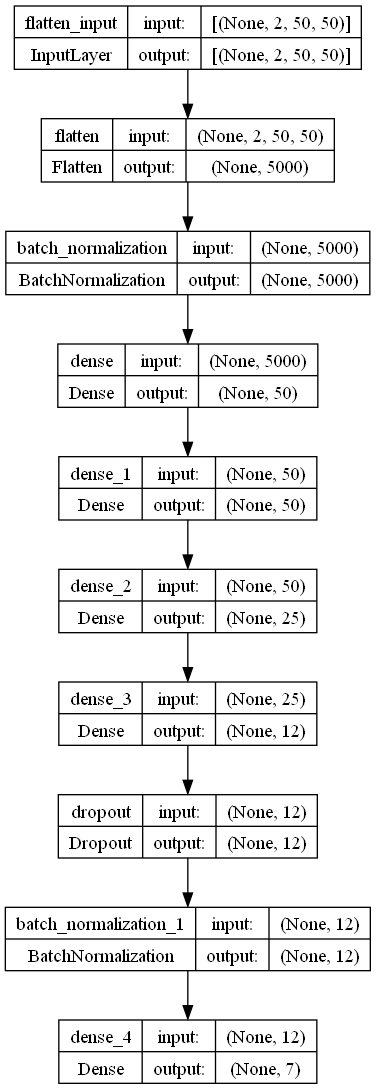

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [27]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [28]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [29]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 11ms/step - loss: 13.3880 - a_1: 2.9008 - a_2: 3.0031 - b_1: 2.3390 - b_2: 2.2731 - d_1: 1.8875 - d_2: 1.6043 - n: 2.5729 - mean_metric: 0.5478 - val_loss: 12.7770 - val_a_1: 3.0917 - val_a_2: 2.8679 - val_b_1: 2.6184 - val_b_2: 1.8610 - val_d_1: 2.0873 - val_d_2: 2.2800 - val_n: 1.7709 - val_mean_metric: 0.5451 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 7ms/step - loss: 10.6086 - a_1: 2.7722 - a_2: 2.8125 - b_1: 1.7814 - b_2: 1.7784 - d_1: 1.4756 - d_2: 1.4244 - n: 2.1869 - mean_metric: 0.4703 - val_loss: 9.5923 - val_a_1: 2.8119 - val_a_2: 2.6575 - val_b_1: 2.0737 - val_b_2: 1.3811 - val_d_1: 1.6123 - val_d_2: 1.5543 - val_n: 1.6049 - val_mean_metric: 0.4503 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 6ms/step - loss: 8.8710 - a_1: 2.6087 - a_2: 2.5347 - b_1: 1.6276 - b_2: 1.6019 - d_1: 1.4820 - d_2: 1.3658 - n: 1.9495 - mean_metric: 0.4353 - val_loss: 7.1449 - val_a_1: 2.565

70/70 [==============================] - 0s 6ms/step - loss: 4.3163 - a_1: 1.7227 - a_2: 1.6952 - b_1: 1.4273 - b_2: 1.3892 - d_1: 1.2670 - d_2: 1.2707 - n: 1.4404 - mean_metric: 0.3375 - val_loss: 2.9933 - val_a_1: 1.4684 - val_a_2: 1.3551 - val_b_1: 1.1013 - val_b_2: 1.0072 - val_d_1: 0.9050 - val_d_2: 0.8544 - val_n: 1.3863 - val_mean_metric: 0.2655 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 0s 6ms/step - loss: 4.3249 - a_1: 1.7394 - a_2: 1.7080 - b_1: 1.4343 - b_2: 1.4055 - d_1: 1.2673 - d_2: 1.2687 - n: 1.4366 - mean_metric: 0.3391 - val_loss: 3.0737 - val_a_1: 1.4836 - val_a_2: 1.3799 - val_b_1: 1.1600 - val_b_2: 1.1004 - val_d_1: 0.8761 - val_d_2: 0.8421 - val_n: 1.3804 - val_mean_metric: 0.2703 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 0s 6ms/step - loss: 4.1660 - a_1: 1.6850 - a_2: 1.6748 - b_1: 1.4063 - b_2: 1.3719 - d_1: 1.2486 - d_2: 1.2615 - n: 1.4236 - mean_metric: 0.3328 - val_loss: 2.9861 - val_a_1: 1.4652 - val_a_2: 1.

70/70 [==============================] - 0s 6ms/step - loss: 3.7319 - a_1: 1.6163 - a_2: 1.6186 - b_1: 1.3279 - b_2: 1.3129 - d_1: 1.2063 - d_2: 1.1980 - n: 1.4173 - mean_metric: 0.3206 - val_loss: 2.4674 - val_a_1: 1.2827 - val_a_2: 1.2754 - val_b_1: 0.9651 - val_b_2: 0.9554 - val_d_1: 0.7552 - val_d_2: 0.7649 - val_n: 1.3667 - val_mean_metric: 0.2421 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.7009 - a_1: 1.6257 - a_2: 1.6203 - b_1: 1.3312 - b_2: 1.3189 - d_1: 1.2004 - d_2: 1.1712 - n: 1.4076 - mean_metric: 0.3197 - val_loss: 2.4189 - val_a_1: 1.3107 - val_a_2: 1.2273 - val_b_1: 0.9234 - val_b_2: 0.8934 - val_d_1: 0.9121 - val_d_2: 0.6853 - val_n: 1.3624 - val_mean_metric: 0.2405 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.6940 - a_1: 1.6212 - a_2: 1.5891 - b_1: 1.3454 - b_2: 1.3173 - d_1: 1.2233 - d_2: 1.1972 - n: 1.4050 - mean_metric: 0.3206 - val_loss: 2.3883 - val_a_1: 1.3257 - val_a_2: 1.

70/70 [==============================] - 0s 6ms/step - loss: 3.3059 - a_1: 1.5498 - a_2: 1.5438 - b_1: 1.2744 - b_2: 1.2614 - d_1: 1.1467 - d_2: 1.0793 - n: 1.3990 - mean_metric: 0.3058 - val_loss: 2.0384 - val_a_1: 1.2338 - val_a_2: 1.1468 - val_b_1: 0.9417 - val_b_2: 0.8374 - val_d_1: 0.7280 - val_d_2: 0.6278 - val_n: 1.3556 - val_mean_metric: 0.2259 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.2082 - a_1: 1.5418 - a_2: 1.5146 - b_1: 1.2545 - b_2: 1.2405 - d_1: 1.1148 - d_2: 1.0632 - n: 1.3980 - mean_metric: 0.3017 - val_loss: 2.0255 - val_a_1: 1.2584 - val_a_2: 1.1659 - val_b_1: 0.9536 - val_b_2: 0.8031 - val_d_1: 0.7161 - val_d_2: 0.5737 - val_n: 1.3584 - val_mean_metric: 0.2245 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.2190 - a_1: 1.5534 - a_2: 1.5230 - b_1: 1.2549 - b_2: 1.2329 - d_1: 1.1275 - d_2: 1.0482 - n: 1.3998 - mean_metric: 0.3020 - val_loss: 2.1313 - val_a_1: 1.3337 - val_a_2: 1.

70/70 [==============================] - 0s 6ms/step - loss: 3.0247 - a_1: 1.4927 - a_2: 1.4977 - b_1: 1.2128 - b_2: 1.2024 - d_1: 1.0470 - d_2: 0.9670 - n: 1.4019 - mean_metric: 0.2916 - val_loss: 1.7882 - val_a_1: 1.1305 - val_a_2: 1.1467 - val_b_1: 0.7753 - val_b_2: 0.7132 - val_d_1: 0.7337 - val_d_2: 0.5707 - val_n: 1.3581 - val_mean_metric: 0.2114 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.0548 - a_1: 1.5087 - a_2: 1.4939 - b_1: 1.2225 - b_2: 1.2016 - d_1: 1.0905 - d_2: 0.9628 - n: 1.3984 - mean_metric: 0.2934 - val_loss: 1.7643 - val_a_1: 1.1529 - val_a_2: 1.0593 - val_b_1: 0.8366 - val_b_2: 0.7856 - val_d_1: 0.6074 - val_d_2: 0.4945 - val_n: 1.3541 - val_mean_metric: 0.2068 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 0s 6ms/step - loss: 3.0487 - a_1: 1.4892 - a_2: 1.4991 - b_1: 1.2126 - b_2: 1.2200 - d_1: 1.0790 - d_2: 0.9829 - n: 1.3935 - mean_metric: 0.2934 - val_loss: 1.7526 - val_a_1: 1.1631 - val_a_2: 1.

70/70 [==============================] - 0s 7ms/step - loss: 2.9852 - a_1: 1.4714 - a_2: 1.4617 - b_1: 1.2170 - b_2: 1.1920 - d_1: 1.0726 - d_2: 0.9359 - n: 1.3933 - mean_metric: 0.2890 - val_loss: 1.6955 - val_a_1: 1.1073 - val_a_2: 1.0710 - val_b_1: 0.7279 - val_b_2: 0.7814 - val_d_1: 0.5639 - val_d_2: 0.4922 - val_n: 1.3508 - val_mean_metric: 0.2004 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 0s 7ms/step - loss: 3.0286 - a_1: 1.4361 - a_2: 1.4769 - b_1: 1.2482 - b_2: 1.2120 - d_1: 1.0909 - d_2: 0.9312 - n: 1.3919 - mean_metric: 0.2904 - val_loss: 1.7240 - val_a_1: 1.0886 - val_a_2: 1.0367 - val_b_1: 0.7845 - val_b_2: 0.7503 - val_d_1: 0.6136 - val_d_2: 0.6094 - val_n: 1.3493 - val_mean_metric: 0.2049 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.9783 - a_1: 1.4496 - a_2: 1.4485 - b_1: 1.2095 - b_2: 1.1891 - d_1: 1.0591 - d_2: 0.9510 - n: 1.3959 - mean_metric: 0.2876 - val_loss: 1.6409 - val_a_1: 1.0338 - val_a_2: 

70/70 [==============================] - 0s 7ms/step - loss: 2.9348 - a_1: 1.4363 - a_2: 1.4738 - b_1: 1.1871 - b_2: 1.1688 - d_1: 1.0384 - d_2: 0.9087 - n: 1.3887 - mean_metric: 0.2843 - val_loss: 1.6413 - val_a_1: 1.0569 - val_a_2: 1.0177 - val_b_1: 0.7269 - val_b_2: 0.7392 - val_d_1: 0.6436 - val_d_2: 0.4690 - val_n: 1.3463 - val_mean_metric: 0.1973 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.8971 - a_1: 1.4191 - a_2: 1.4325 - b_1: 1.1904 - b_2: 1.1615 - d_1: 1.0182 - d_2: 0.9093 - n: 1.3913 - mean_metric: 0.2816 - val_loss: 1.6651 - val_a_1: 1.0181 - val_a_2: 1.0200 - val_b_1: 0.8866 - val_b_2: 0.6953 - val_d_1: 0.7480 - val_d_2: 0.4160 - val_n: 1.3441 - val_mean_metric: 0.2015 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.9031 - a_1: 1.4171 - a_2: 1.4323 - b_1: 1.1945 - b_2: 1.1715 - d_1: 1.0438 - d_2: 0.8801 - n: 1.3877 - mean_metric: 0.2818 - val_loss: 1.6343 - val_a_1: 1.0591 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.8345 - a_1: 1.4041 - a_2: 1.4303 - b_1: 1.1671 - b_2: 1.1324 - d_1: 1.0059 - d_2: 0.8565 - n: 1.3672 - mean_metric: 0.2765 - val_loss: 1.6276 - val_a_1: 1.0042 - val_a_2: 0.9782 - val_b_1: 0.9186 - val_b_2: 0.7538 - val_d_1: 0.5340 - val_d_2: 0.4988 - val_n: 1.3168 - val_mean_metric: 0.1974 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.8623 - a_1: 1.4239 - a_2: 1.4452 - b_1: 1.1717 - b_2: 1.1419 - d_1: 1.0230 - d_2: 0.8529 - n: 1.3622 - mean_metric: 0.2784 - val_loss: 1.5766 - val_a_1: 1.0056 - val_a_2: 0.9581 - val_b_1: 0.7147 - val_b_2: 0.7580 - val_d_1: 0.5721 - val_d_2: 0.4537 - val_n: 1.3147 - val_mean_metric: 0.1899 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.8626 - a_1: 1.4317 - a_2: 1.4339 - b_1: 1.1526 - b_2: 1.1412 - d_1: 1.0399 - d_2: 0.8607 - n: 1.3487 - mean_metric: 0.2779 - val_loss: 1.5817 - val_a_1: 0.9973 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.8174 - a_1: 1.4252 - a_2: 1.4418 - b_1: 1.1993 - b_2: 1.1312 - d_1: 1.0021 - d_2: 0.8423 - n: 1.2396 - mean_metric: 0.2737 - val_loss: 1.5235 - val_a_1: 1.0371 - val_a_2: 1.0379 - val_b_1: 0.7606 - val_b_2: 0.7211 - val_d_1: 0.6529 - val_d_2: 0.4193 - val_n: 1.1443 - val_mean_metric: 0.1899 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.7974 - a_1: 1.4309 - a_2: 1.4305 - b_1: 1.1808 - b_2: 1.1350 - d_1: 0.9984 - d_2: 0.8584 - n: 1.2278 - mean_metric: 0.2731 - val_loss: 1.5613 - val_a_1: 1.1053 - val_a_2: 0.9355 - val_b_1: 0.8826 - val_b_2: 0.7408 - val_d_1: 0.5717 - val_d_2: 0.6259 - val_n: 1.1205 - val_mean_metric: 0.1967 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.8164 - a_1: 1.4254 - a_2: 1.4265 - b_1: 1.1954 - b_2: 1.1458 - d_1: 1.0153 - d_2: 0.8641 - n: 1.2228 - mean_metric: 0.2742 - val_loss: 1.4892 - val_a_1: 0.9998 - val_a_2: 

70/70 [==============================] - 0s 7ms/step - loss: 2.7780 - a_1: 1.3891 - a_2: 1.4155 - b_1: 1.2408 - b_2: 1.1028 - d_1: 1.0068 - d_2: 0.8438 - n: 1.1796 - mean_metric: 0.2703 - val_loss: 1.4629 - val_a_1: 1.0127 - val_a_2: 0.9409 - val_b_1: 0.7499 - val_b_2: 0.7951 - val_d_1: 0.6720 - val_d_2: 0.5089 - val_n: 1.0354 - val_mean_metric: 0.1879 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7404 - a_1: 1.3902 - a_2: 1.3744 - b_1: 1.2070 - b_2: 1.1239 - d_1: 1.0034 - d_2: 0.8563 - n: 1.1730 - mean_metric: 0.2686 - val_loss: 1.4735 - val_a_1: 1.0548 - val_a_2: 0.9710 - val_b_1: 0.7577 - val_b_2: 0.8437 - val_d_1: 0.5813 - val_d_2: 0.5262 - val_n: 1.0279 - val_mean_metric: 0.1895 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7835 - a_1: 1.4065 - a_2: 1.4232 - b_1: 1.2235 - b_2: 1.1296 - d_1: 1.0160 - d_2: 0.8583 - n: 1.1681 - mean_metric: 0.2718 - val_loss: 1.4245 - val_a_1: 0.9571 - val_a_2: 

70/70 [==============================] - 0s 7ms/step - loss: 2.7767 - a_1: 1.4058 - a_2: 1.3956 - b_1: 1.2186 - b_2: 1.1286 - d_1: 1.0284 - d_2: 0.8379 - n: 1.1689 - mean_metric: 0.2705 - val_loss: 1.4226 - val_a_1: 0.9896 - val_a_2: 1.0586 - val_b_1: 0.7101 - val_b_2: 0.7128 - val_d_1: 0.5353 - val_d_2: 0.4635 - val_n: 1.0148 - val_mean_metric: 0.1803 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7212 - a_1: 1.3919 - a_2: 1.3836 - b_1: 1.2311 - b_2: 1.0841 - d_1: 0.9868 - d_2: 0.8370 - n: 1.1705 - mean_metric: 0.2672 - val_loss: 1.3793 - val_a_1: 0.9587 - val_a_2: 0.9156 - val_b_1: 0.7126 - val_b_2: 0.6905 - val_d_1: 0.5315 - val_d_2: 0.5660 - val_n: 1.0150 - val_mean_metric: 0.1772 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7590 - a_1: 1.4010 - a_2: 1.3833 - b_1: 1.2183 - b_2: 1.1282 - d_1: 1.0074 - d_2: 0.8723 - n: 1.1590 - mean_metric: 0.2701 - val_loss: 1.4421 - val_a_1: 0.9473 - val_a_2: 

70/70 [==============================] - 0s 7ms/step - loss: 2.7454 - a_1: 1.3982 - a_2: 1.3828 - b_1: 1.2231 - b_2: 1.1279 - d_1: 1.0258 - d_2: 0.8338 - n: 1.1531 - mean_metric: 0.2692 - val_loss: 1.4282 - val_a_1: 0.9971 - val_a_2: 0.9315 - val_b_1: 0.8072 - val_b_2: 0.7605 - val_d_1: 0.6515 - val_d_2: 0.5291 - val_n: 1.0271 - val_mean_metric: 0.1875 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7408 - a_1: 1.4124 - a_2: 1.3778 - b_1: 1.2110 - b_2: 1.1449 - d_1: 0.9950 - d_2: 0.8335 - n: 1.1456 - mean_metric: 0.2685 - val_loss: 1.4785 - val_a_1: 1.0044 - val_a_2: 1.1227 - val_b_1: 0.8912 - val_b_2: 0.7151 - val_d_1: 0.5162 - val_d_2: 0.5780 - val_n: 1.0035 - val_mean_metric: 0.1917 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 0s 7ms/step - loss: 2.7262 - a_1: 1.3958 - a_2: 1.3862 - b_1: 1.1987 - b_2: 1.1303 - d_1: 1.0073 - d_2: 0.8418 - n: 1.1324 - mean_metric: 0.2674 - val_loss: 1.4039 - val_a_1: 1.0524 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6465 - a_1: 1.3972 - a_2: 1.3243 - b_1: 1.2096 - b_2: 1.1219 - d_1: 0.9944 - d_2: 0.7793 - n: 1.0969 - mean_metric: 0.2619 - val_loss: 1.4427 - val_a_1: 1.1037 - val_a_2: 0.9788 - val_b_1: 0.7106 - val_b_2: 0.8243 - val_d_1: 0.5674 - val_d_2: 0.4935 - val_n: 0.9400 - val_mean_metric: 0.1847 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.7227 - a_1: 1.3824 - a_2: 1.3591 - b_1: 1.1860 - b_2: 1.1612 - d_1: 1.0156 - d_2: 0.8413 - n: 1.1158 - mean_metric: 0.2665 - val_loss: 1.4252 - val_a_1: 0.9429 - val_a_2: 0.9666 - val_b_1: 0.7118 - val_b_2: 0.8399 - val_d_1: 0.6546 - val_d_2: 0.5593 - val_n: 0.9360 - val_mean_metric: 0.1845 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6902 - a_1: 1.3839 - a_2: 1.3610 - b_1: 1.1849 - b_2: 1.1472 - d_1: 1.0008 - d_2: 0.8416 - n: 1.1184 - mean_metric: 0.2657 - val_loss: 1.3706 - val_a_1: 0.9263 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6222 - a_1: 1.3612 - a_2: 1.3391 - b_1: 1.1474 - b_2: 1.1291 - d_1: 0.9829 - d_2: 0.8475 - n: 1.0873 - mean_metric: 0.2609 - val_loss: 1.3930 - val_a_1: 0.9958 - val_a_2: 0.9346 - val_b_1: 0.7088 - val_b_2: 0.7958 - val_d_1: 0.6145 - val_d_2: 0.6112 - val_n: 0.8953 - val_mean_metric: 0.1827 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.7161 - a_1: 1.3711 - a_2: 1.3676 - b_1: 1.1818 - b_2: 1.1506 - d_1: 1.0119 - d_2: 0.8331 - n: 1.0877 - mean_metric: 0.2646 - val_loss: 1.3625 - val_a_1: 0.9499 - val_a_2: 0.9102 - val_b_1: 0.7006 - val_b_2: 0.7514 - val_d_1: 0.5628 - val_d_2: 0.6034 - val_n: 0.9050 - val_mean_metric: 0.1770 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6621 - a_1: 1.3546 - a_2: 1.3675 - b_1: 1.1708 - b_2: 1.1316 - d_1: 0.9880 - d_2: 0.8468 - n: 1.0962 - mean_metric: 0.2630 - val_loss: 1.3918 - val_a_1: 0.9504 - val_a_2: 

70/70 [==============================] - 0s 7ms/step - loss: 2.6684 - a_1: 1.3891 - a_2: 1.3515 - b_1: 1.1709 - b_2: 1.1119 - d_1: 0.9948 - d_2: 0.8078 - n: 1.0824 - mean_metric: 0.2614 - val_loss: 1.3577 - val_a_1: 0.9859 - val_a_2: 0.9748 - val_b_1: 0.6850 - val_b_2: 0.7996 - val_d_1: 0.5243 - val_d_2: 0.5026 - val_n: 0.8509 - val_mean_metric: 0.1750 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5982 - a_1: 1.3316 - a_2: 1.3463 - b_1: 1.1353 - b_2: 1.1143 - d_1: 1.0069 - d_2: 0.8160 - n: 1.0652 - mean_metric: 0.2583 - val_loss: 1.3097 - val_a_1: 0.9095 - val_a_2: 0.9063 - val_b_1: 0.7428 - val_b_2: 0.7463 - val_d_1: 0.5384 - val_d_2: 0.4794 - val_n: 0.8676 - val_mean_metric: 0.1707 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6840 - a_1: 1.3819 - a_2: 1.3649 - b_1: 1.1690 - b_2: 1.1281 - d_1: 0.9965 - d_2: 0.8292 - n: 1.0936 - mean_metric: 0.2632 - val_loss: 1.3653 - val_a_1: 0.9772 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6329 - a_1: 1.3641 - a_2: 1.3783 - b_1: 1.1549 - b_2: 1.1126 - d_1: 1.0004 - d_2: 0.7984 - n: 1.0684 - mean_metric: 0.2604 - val_loss: 1.3279 - val_a_1: 0.9169 - val_a_2: 0.9214 - val_b_1: 0.7007 - val_b_2: 0.7737 - val_d_1: 0.5854 - val_d_2: 0.5097 - val_n: 0.8781 - val_mean_metric: 0.1738 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6051 - a_1: 1.3522 - a_2: 1.3469 - b_1: 1.1391 - b_2: 1.1238 - d_1: 0.9983 - d_2: 0.8267 - n: 1.0620 - mean_metric: 0.2595 - val_loss: 1.3273 - val_a_1: 0.8985 - val_a_2: 0.9118 - val_b_1: 0.7057 - val_b_2: 0.7620 - val_d_1: 0.5953 - val_d_2: 0.4893 - val_n: 0.8673 - val_mean_metric: 0.1720 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6278 - a_1: 1.3744 - a_2: 1.3256 - b_1: 1.1398 - b_2: 1.1035 - d_1: 1.0181 - d_2: 0.7859 - n: 1.0714 - mean_metric: 0.2585 - val_loss: 1.3379 - val_a_1: 0.9535 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6091 - a_1: 1.3518 - a_2: 1.3483 - b_1: 1.1305 - b_2: 1.1080 - d_1: 0.9926 - d_2: 0.8339 - n: 1.0540 - mean_metric: 0.2584 - val_loss: 1.3420 - val_a_1: 0.9336 - val_a_2: 0.9152 - val_b_1: 0.7232 - val_b_2: 0.7889 - val_d_1: 0.5437 - val_d_2: 0.5496 - val_n: 0.8603 - val_mean_metric: 0.1747 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6118 - a_1: 1.3643 - a_2: 1.3385 - b_1: 1.1608 - b_2: 1.0904 - d_1: 0.9699 - d_2: 0.8474 - n: 1.0643 - mean_metric: 0.2591 - val_loss: 1.3178 - val_a_1: 0.9178 - val_a_2: 0.9003 - val_b_1: 0.7019 - val_b_2: 0.7298 - val_d_1: 0.6280 - val_d_2: 0.5498 - val_n: 0.8756 - val_mean_metric: 0.1744 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6067 - a_1: 1.3721 - a_2: 1.3439 - b_1: 1.1416 - b_2: 1.0804 - d_1: 1.0164 - d_2: 0.8430 - n: 1.0671 - mean_metric: 0.2599 - val_loss: 1.3074 - val_a_1: 0.9351 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6449 - a_1: 1.3912 - a_2: 1.3484 - b_1: 1.1395 - b_2: 1.1169 - d_1: 0.9967 - d_2: 0.8335 - n: 1.0692 - mean_metric: 0.2610 - val_loss: 1.3142 - val_a_1: 0.9525 - val_a_2: 0.9373 - val_b_1: 0.7293 - val_b_2: 0.7511 - val_d_1: 0.5490 - val_d_2: 0.4512 - val_n: 0.8445 - val_mean_metric: 0.1715 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6071 - a_1: 1.3612 - a_2: 1.3336 - b_1: 1.1508 - b_2: 1.1015 - d_1: 1.0016 - d_2: 0.7864 - n: 1.0737 - mean_metric: 0.2582 - val_loss: 1.3555 - val_a_1: 0.9345 - val_a_2: 0.9417 - val_b_1: 0.7148 - val_b_2: 0.8574 - val_d_1: 0.5444 - val_d_2: 0.5948 - val_n: 0.8590 - val_mean_metric: 0.1791 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6098 - a_1: 1.3588 - a_2: 1.3551 - b_1: 1.1478 - b_2: 1.1006 - d_1: 0.9803 - d_2: 0.7993 - n: 1.1053 - mean_metric: 0.2594 - val_loss: 1.3250 - val_a_1: 0.9219 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6165 - a_1: 1.3554 - a_2: 1.3619 - b_1: 1.1500 - b_2: 1.1073 - d_1: 0.9911 - d_2: 0.8061 - n: 1.0646 - mean_metric: 0.2590 - val_loss: 1.3076 - val_a_1: 0.9313 - val_a_2: 0.9733 - val_b_1: 0.6826 - val_b_2: 0.7299 - val_d_1: 0.5715 - val_d_2: 0.5195 - val_n: 0.8432 - val_mean_metric: 0.1727 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5643 - a_1: 1.3482 - a_2: 1.3399 - b_1: 1.1380 - b_2: 1.1074 - d_1: 0.9763 - d_2: 0.8046 - n: 1.0555 - mean_metric: 0.2569 - val_loss: 1.2711 - val_a_1: 0.9471 - val_a_2: 0.9118 - val_b_1: 0.7031 - val_b_2: 0.7369 - val_d_1: 0.5277 - val_d_2: 0.5134 - val_n: 0.8213 - val_mean_metric: 0.1697 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6387 - a_1: 1.3774 - a_2: 1.3377 - b_1: 1.1139 - b_2: 1.1186 - d_1: 1.0228 - d_2: 0.8415 - n: 1.0735 - mean_metric: 0.2607 - val_loss: 1.2846 - val_a_1: 0.9163 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6117 - a_1: 1.3597 - a_2: 1.3563 - b_1: 1.1315 - b_2: 1.1177 - d_1: 0.9926 - d_2: 0.8025 - n: 1.0888 - mean_metric: 0.2595 - val_loss: 1.3115 - val_a_1: 0.9617 - val_a_2: 0.8871 - val_b_1: 0.7587 - val_b_2: 0.7426 - val_d_1: 0.5394 - val_d_2: 0.5010 - val_n: 0.8849 - val_mean_metric: 0.1735 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6496 - a_1: 1.3512 - a_2: 1.3745 - b_1: 1.1611 - b_2: 1.1067 - d_1: 1.0043 - d_2: 0.8293 - n: 1.0760 - mean_metric: 0.2612 - val_loss: 1.3150 - val_a_1: 0.9717 - val_a_2: 0.9095 - val_b_1: 0.7243 - val_b_2: 0.7963 - val_d_1: 0.5038 - val_d_2: 0.4283 - val_n: 0.8573 - val_mean_metric: 0.1707 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6197 - a_1: 1.3946 - a_2: 1.3334 - b_1: 1.1425 - b_2: 1.1031 - d_1: 0.9980 - d_2: 0.8152 - n: 1.0658 - mean_metric: 0.2596 - val_loss: 1.3073 - val_a_1: 0.9594 - val_a_2: 

70/70 [==============================] - 0s 6ms/step - loss: 2.6440 - a_1: 1.3923 - a_2: 1.3415 - b_1: 1.1477 - b_2: 1.1175 - d_1: 0.9981 - d_2: 0.8241 - n: 1.0669 - mean_metric: 0.2608 - val_loss: 1.3162 - val_a_1: 0.9402 - val_a_2: 0.9150 - val_b_1: 0.7696 - val_b_2: 0.7649 - val_d_1: 0.6289 - val_d_2: 0.4148 - val_n: 0.8344 - val_mean_metric: 0.1732 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6315 - a_1: 1.3700 - a_2: 1.3632 - b_1: 1.1228 - b_2: 1.0953 - d_1: 1.0043 - d_2: 0.8323 - n: 1.0628 - mean_metric: 0.2596 - val_loss: 1.2915 - val_a_1: 0.9329 - val_a_2: 0.8833 - val_b_1: 0.7117 - val_b_2: 0.8699 - val_d_1: 0.5166 - val_d_2: 0.4070 - val_n: 0.8183 - val_mean_metric: 0.1690 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6308 - a_1: 1.3591 - a_2: 1.3476 - b_1: 1.1625 - b_2: 1.0898 - d_1: 0.9969 - d_2: 0.8395 - n: 1.0812 - mean_metric: 0.2603 - val_loss: 1.2856 - val_a_1: 0.9010 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5878 - a_1: 1.3673 - a_2: 1.3446 - b_1: 1.1302 - b_2: 1.1045 - d_1: 0.9674 - d_2: 0.8001 - n: 1.0714 - mean_metric: 0.2574 - val_loss: 1.2818 - val_a_1: 0.9387 - val_a_2: 0.9271 - val_b_1: 0.6734 - val_b_2: 0.7847 - val_d_1: 0.5104 - val_d_2: 0.5061 - val_n: 0.8197 - val_mean_metric: 0.1697 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6217 - a_1: 1.3722 - a_2: 1.3369 - b_1: 1.1397 - b_2: 1.0842 - d_1: 1.0087 - d_2: 0.8222 - n: 1.0747 - mean_metric: 0.2591 - val_loss: 1.2683 - val_a_1: 0.9232 - val_a_2: 0.8696 - val_b_1: 0.7269 - val_b_2: 0.7276 - val_d_1: 0.5351 - val_d_2: 0.5354 - val_n: 0.8335 - val_mean_metric: 0.1694 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6210 - a_1: 1.3697 - a_2: 1.3583 - b_1: 1.1393 - b_2: 1.1022 - d_1: 0.9827 - d_2: 0.8143 - n: 1.0705 - mean_metric: 0.2590 - val_loss: 1.2880 - val_a_1: 0.8981 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.6284 - a_1: 1.3763 - a_2: 1.3197 - b_1: 1.1279 - b_2: 1.1235 - d_1: 1.0127 - d_2: 0.8285 - n: 1.0707 - mean_metric: 0.2598 - val_loss: 1.2827 - val_a_1: 0.9266 - val_a_2: 0.8765 - val_b_1: 0.7236 - val_b_2: 0.7362 - val_d_1: 0.5780 - val_d_2: 0.4847 - val_n: 0.8586 - val_mean_metric: 0.1705 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6115 - a_1: 1.3677 - a_2: 1.3469 - b_1: 1.1544 - b_2: 1.0830 - d_1: 0.9906 - d_2: 0.7888 - n: 1.0741 - mean_metric: 0.2581 - val_loss: 1.2890 - val_a_1: 0.9159 - val_a_2: 0.8954 - val_b_1: 0.7544 - val_b_2: 0.7962 - val_d_1: 0.5256 - val_d_2: 0.4690 - val_n: 0.8629 - val_mean_metric: 0.1716 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6027 - a_1: 1.3779 - a_2: 1.3515 - b_1: 1.1218 - b_2: 1.0935 - d_1: 0.9974 - d_2: 0.8197 - n: 1.0726 - mean_metric: 0.2591 - val_loss: 1.2595 - val_a_1: 0.9144 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5685 - a_1: 1.3550 - a_2: 1.3322 - b_1: 1.1397 - b_2: 1.0763 - d_1: 1.0048 - d_2: 0.7979 - n: 1.0556 - mean_metric: 0.2565 - val_loss: 1.2822 - val_a_1: 0.9030 - val_a_2: 0.9822 - val_b_1: 0.7631 - val_b_2: 0.7222 - val_d_1: 0.5241 - val_d_2: 0.4475 - val_n: 0.8332 - val_mean_metric: 0.1702 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6014 - a_1: 1.3552 - a_2: 1.3405 - b_1: 1.1251 - b_2: 1.0839 - d_1: 1.0171 - d_2: 0.7935 - n: 1.0654 - mean_metric: 0.2572 - val_loss: 1.2705 - val_a_1: 0.8961 - val_a_2: 0.8872 - val_b_1: 0.7459 - val_b_2: 0.7460 - val_d_1: 0.6975 - val_d_2: 0.4165 - val_n: 0.8811 - val_mean_metric: 0.1733 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5592 - a_1: 1.3593 - a_2: 1.3136 - b_1: 1.1411 - b_2: 1.1094 - d_1: 0.9709 - d_2: 0.7781 - n: 1.0680 - mean_metric: 0.2559 - val_loss: 1.3164 - val_a_1: 0.8811 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.6058 - a_1: 1.3754 - a_2: 1.3289 - b_1: 1.1272 - b_2: 1.0967 - d_1: 1.0082 - d_2: 0.8345 - n: 1.0667 - mean_metric: 0.2591 - val_loss: 1.2929 - val_a_1: 0.9901 - val_a_2: 0.9669 - val_b_1: 0.7052 - val_b_2: 0.7798 - val_d_1: 0.5239 - val_d_2: 0.4483 - val_n: 0.8565 - val_mean_metric: 0.1733 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6083 - a_1: 1.3545 - a_2: 1.3505 - b_1: 1.1250 - b_2: 1.0957 - d_1: 0.9978 - d_2: 0.8355 - n: 1.0742 - mean_metric: 0.2589 - val_loss: 1.2832 - val_a_1: 0.9012 - val_a_2: 0.8943 - val_b_1: 0.8259 - val_b_2: 0.7553 - val_d_1: 0.6112 - val_d_2: 0.4504 - val_n: 0.8525 - val_mean_metric: 0.1740 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6144 - a_1: 1.3862 - a_2: 1.3536 - b_1: 1.1449 - b_2: 1.0856 - d_1: 0.9888 - d_2: 0.8089 - n: 1.0767 - mean_metric: 0.2594 - val_loss: 1.2527 - val_a_1: 0.9080 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5670 - a_1: 1.3755 - a_2: 1.3406 - b_1: 1.1352 - b_2: 1.1074 - d_1: 0.9628 - d_2: 0.8118 - n: 1.0537 - mean_metric: 0.2574 - val_loss: 1.2400 - val_a_1: 0.8814 - val_a_2: 0.8785 - val_b_1: 0.7259 - val_b_2: 0.7324 - val_d_1: 0.5976 - val_d_2: 0.4518 - val_n: 0.8462 - val_mean_metric: 0.1681 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6249 - a_1: 1.3725 - a_2: 1.3493 - b_1: 1.1487 - b_2: 1.0936 - d_1: 1.0070 - d_2: 0.8159 - n: 1.0706 - mean_metric: 0.2598 - val_loss: 1.2570 - val_a_1: 0.9844 - val_a_2: 0.8685 - val_b_1: 0.6760 - val_b_2: 0.7829 - val_d_1: 0.5324 - val_d_2: 0.4095 - val_n: 0.8534 - val_mean_metric: 0.1679 - lr: 7.9210e-04
Epoch 528/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5776 - a_1: 1.3463 - a_2: 1.3473 - b_1: 1.1377 - b_2: 1.0983 - d_1: 0.9689 - d_2: 0.7874 - n: 1.0509 - mean_metric: 0.2557 - val_loss: 1.2388 - val_a_1: 0.8994 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5590 - a_1: 1.3575 - a_2: 1.3476 - b_1: 1.0989 - b_2: 1.0778 - d_1: 0.9818 - d_2: 0.8178 - n: 1.0598 - mean_metric: 0.2559 - val_loss: 1.2797 - val_a_1: 0.9176 - val_a_2: 0.8810 - val_b_1: 0.6951 - val_b_2: 0.7368 - val_d_1: 0.6450 - val_d_2: 0.5156 - val_n: 0.8300 - val_mean_metric: 0.1717 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5771 - a_1: 1.3608 - a_2: 1.3452 - b_1: 1.1345 - b_2: 1.1033 - d_1: 0.9916 - d_2: 0.7878 - n: 1.0676 - mean_metric: 0.2575 - val_loss: 1.2747 - val_a_1: 0.9038 - val_a_2: 0.8738 - val_b_1: 0.8303 - val_b_2: 0.8423 - val_d_1: 0.6155 - val_d_2: 0.4066 - val_n: 0.8136 - val_mean_metric: 0.1738 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5994 - a_1: 1.3682 - a_2: 1.3360 - b_1: 1.1545 - b_2: 1.0887 - d_1: 0.9922 - d_2: 0.7918 - n: 1.0457 - mean_metric: 0.2570 - val_loss: 1.2688 - val_a_1: 0.9769 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5849 - a_1: 1.3518 - a_2: 1.3406 - b_1: 1.1234 - b_2: 1.1027 - d_1: 0.9973 - d_2: 0.7893 - n: 1.0666 - mean_metric: 0.2569 - val_loss: 1.2372 - val_a_1: 0.8953 - val_a_2: 0.8897 - val_b_1: 0.7339 - val_b_2: 0.7339 - val_d_1: 0.5170 - val_d_2: 0.4198 - val_n: 0.8313 - val_mean_metric: 0.1651 - lr: 7.2445e-04
Epoch 569/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5484 - a_1: 1.3356 - a_2: 1.3345 - b_1: 1.1196 - b_2: 1.0907 - d_1: 0.9828 - d_2: 0.8081 - n: 1.0578 - mean_metric: 0.2555 - val_loss: 1.2551 - val_a_1: 0.9036 - val_a_2: 0.8873 - val_b_1: 0.7345 - val_b_2: 0.8006 - val_d_1: 0.5477 - val_d_2: 0.5097 - val_n: 0.8308 - val_mean_metric: 0.1714 - lr: 7.2280e-04
Epoch 570/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5708 - a_1: 1.3535 - a_2: 1.3258 - b_1: 1.1442 - b_2: 1.1097 - d_1: 0.9905 - d_2: 0.7897 - n: 1.0625 - mean_metric: 0.2570 - val_loss: 1.2540 - val_a_1: 0.9041 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5931 - a_1: 1.3695 - a_2: 1.3374 - b_1: 1.1104 - b_2: 1.1054 - d_1: 0.9888 - d_2: 0.8204 - n: 1.0649 - mean_metric: 0.2576 - val_loss: 1.2265 - val_a_1: 0.9150 - val_a_2: 0.8791 - val_b_1: 0.6836 - val_b_2: 0.7286 - val_d_1: 0.5180 - val_d_2: 0.3760 - val_n: 0.8729 - val_mean_metric: 0.1635 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5939 - a_1: 1.3616 - a_2: 1.3350 - b_1: 1.1276 - b_2: 1.1171 - d_1: 0.9838 - d_2: 0.8419 - n: 1.0629 - mean_metric: 0.2589 - val_loss: 1.2238 - val_a_1: 0.9067 - val_a_2: 0.8612 - val_b_1: 0.6628 - val_b_2: 0.7103 - val_d_1: 0.5282 - val_d_2: 0.4220 - val_n: 0.8272 - val_mean_metric: 0.1617 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.6032 - a_1: 1.3854 - a_2: 1.3304 - b_1: 1.1575 - b_2: 1.1005 - d_1: 0.9969 - d_2: 0.7706 - n: 1.0865 - mean_metric: 0.2588 - val_loss: 1.2489 - val_a_1: 0.9110 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5694 - a_1: 1.3492 - a_2: 1.3084 - b_1: 1.1375 - b_2: 1.0771 - d_1: 1.0038 - d_2: 0.8169 - n: 1.0491 - mean_metric: 0.2560 - val_loss: 1.2305 - val_a_1: 0.9395 - val_a_2: 0.8863 - val_b_1: 0.6888 - val_b_2: 0.7411 - val_d_1: 0.5062 - val_d_2: 0.4129 - val_n: 0.8326 - val_mean_metric: 0.1646 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5721 - a_1: 1.3571 - a_2: 1.3226 - b_1: 1.1164 - b_2: 1.1009 - d_1: 0.9996 - d_2: 0.8016 - n: 1.0579 - mean_metric: 0.2563 - val_loss: 1.2280 - val_a_1: 0.8911 - val_a_2: 0.8961 - val_b_1: 0.7236 - val_b_2: 0.7089 - val_d_1: 0.6005 - val_d_2: 0.4194 - val_n: 0.8208 - val_mean_metric: 0.1664 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5266 - a_1: 1.3520 - a_2: 1.3253 - b_1: 1.1182 - b_2: 1.0772 - d_1: 0.9829 - d_2: 0.7795 - n: 1.0511 - mean_metric: 0.2542 - val_loss: 1.2282 - val_a_1: 0.9024 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5693 - a_1: 1.3307 - a_2: 1.3571 - b_1: 1.1212 - b_2: 1.0974 - d_1: 0.9961 - d_2: 0.7858 - n: 1.0762 - mean_metric: 0.2567 - val_loss: 1.2141 - val_a_1: 0.8791 - val_a_2: 0.8603 - val_b_1: 0.6786 - val_b_2: 0.7030 - val_d_1: 0.6036 - val_d_2: 0.4257 - val_n: 0.8283 - val_mean_metric: 0.1637 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5397 - a_1: 1.3651 - a_2: 1.3149 - b_1: 1.1248 - b_2: 1.0845 - d_1: 0.9847 - d_2: 0.7762 - n: 1.0598 - mean_metric: 0.2549 - val_loss: 1.2708 - val_a_1: 0.9060 - val_a_2: 0.8455 - val_b_1: 0.6906 - val_b_2: 0.7082 - val_d_1: 0.5869 - val_d_2: 0.6101 - val_n: 0.8304 - val_mean_metric: 0.1702 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5151 - a_1: 1.3503 - a_2: 1.3196 - b_1: 1.0958 - b_2: 1.0818 - d_1: 0.9774 - d_2: 0.8278 - n: 1.0699 - mean_metric: 0.2553 - val_loss: 1.2158 - val_a_1: 0.8981 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5140 - a_1: 1.3235 - a_2: 1.3095 - b_1: 1.1271 - b_2: 1.0828 - d_1: 0.9837 - d_2: 0.7945 - n: 1.0481 - mean_metric: 0.2535 - val_loss: 1.2526 - val_a_1: 0.8719 - val_a_2: 0.8625 - val_b_1: 0.6808 - val_b_2: 0.7322 - val_d_1: 0.5428 - val_d_2: 0.5652 - val_n: 0.8433 - val_mean_metric: 0.1677 - lr: 5.8585e-04
Epoch 653/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5322 - a_1: 1.3188 - a_2: 1.3382 - b_1: 1.1161 - b_2: 1.1063 - d_1: 0.9927 - d_2: 0.7923 - n: 1.0471 - mean_metric: 0.2549 - val_loss: 1.2127 - val_a_1: 0.8868 - val_a_2: 0.8984 - val_b_1: 0.6910 - val_b_2: 0.6926 - val_d_1: 0.5716 - val_d_2: 0.4038 - val_n: 0.8229 - val_mean_metric: 0.1633 - lr: 5.8420e-04
Epoch 654/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5459 - a_1: 1.3656 - a_2: 1.3133 - b_1: 1.1267 - b_2: 1.0846 - d_1: 0.9764 - d_2: 0.7740 - n: 1.0608 - mean_metric: 0.2545 - val_loss: 1.2644 - val_a_1: 0.9387 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5389 - a_1: 1.3472 - a_2: 1.3117 - b_1: 1.1219 - b_2: 1.0979 - d_1: 0.9726 - d_2: 0.8166 - n: 1.0449 - mean_metric: 0.2550 - val_loss: 1.2240 - val_a_1: 0.8874 - val_a_2: 0.8804 - val_b_1: 0.6993 - val_b_2: 0.7917 - val_d_1: 0.6784 - val_d_2: 0.3523 - val_n: 0.8226 - val_mean_metric: 0.1681 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5732 - a_1: 1.3618 - a_2: 1.3146 - b_1: 1.1630 - b_2: 1.0904 - d_1: 0.9980 - d_2: 0.7856 - n: 1.0505 - mean_metric: 0.2566 - val_loss: 1.2478 - val_a_1: 0.9225 - val_a_2: 0.8591 - val_b_1: 0.7906 - val_b_2: 0.7153 - val_d_1: 0.5587 - val_d_2: 0.4697 - val_n: 0.8494 - val_mean_metric: 0.1698 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5687 - a_1: 1.3601 - a_2: 1.3226 - b_1: 1.1196 - b_2: 1.1042 - d_1: 0.9894 - d_2: 0.8101 - n: 1.0702 - mean_metric: 0.2570 - val_loss: 1.1973 - val_a_1: 0.8772 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5060 - a_1: 1.3430 - a_2: 1.3073 - b_1: 1.0939 - b_2: 1.0846 - d_1: 1.0096 - d_2: 0.7726 - n: 1.0474 - mean_metric: 0.2531 - val_loss: 1.2305 - val_a_1: 0.9063 - val_a_2: 0.8631 - val_b_1: 0.6816 - val_b_2: 0.8420 - val_d_1: 0.4826 - val_d_2: 0.4656 - val_n: 0.8217 - val_mean_metric: 0.1665 - lr: 5.1655e-04
Epoch 695/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5566 - a_1: 1.3388 - a_2: 1.3182 - b_1: 1.1508 - b_2: 1.0903 - d_1: 0.9839 - d_2: 0.7997 - n: 1.0700 - mean_metric: 0.2562 - val_loss: 1.2514 - val_a_1: 0.8905 - val_a_2: 0.8985 - val_b_1: 0.6796 - val_b_2: 0.7099 - val_d_1: 0.5952 - val_d_2: 0.5317 - val_n: 0.8471 - val_mean_metric: 0.1694 - lr: 5.1490e-04
Epoch 696/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5580 - a_1: 1.3572 - a_2: 1.3261 - b_1: 1.1282 - b_2: 1.0810 - d_1: 0.9968 - d_2: 0.8062 - n: 1.0629 - mean_metric: 0.2564 - val_loss: 1.2054 - val_a_1: 0.8987 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5748 - a_1: 1.3705 - a_2: 1.3256 - b_1: 1.1201 - b_2: 1.1111 - d_1: 0.9790 - d_2: 0.7773 - n: 1.0729 - mean_metric: 0.2564 - val_loss: 1.2075 - val_a_1: 0.9018 - val_a_2: 0.8864 - val_b_1: 0.6979 - val_b_2: 0.7532 - val_d_1: 0.5371 - val_d_2: 0.4062 - val_n: 0.8231 - val_mean_metric: 0.1646 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5567 - a_1: 1.3431 - a_2: 1.3385 - b_1: 1.1127 - b_2: 1.1030 - d_1: 1.0019 - d_2: 0.8021 - n: 1.0681 - mean_metric: 0.2567 - val_loss: 1.2429 - val_a_1: 0.8815 - val_a_2: 0.8941 - val_b_1: 0.6913 - val_b_2: 0.7824 - val_d_1: 0.7211 - val_d_2: 0.3833 - val_n: 0.8383 - val_mean_metric: 0.1707 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5899 - a_1: 1.3652 - a_2: 1.3224 - b_1: 1.1257 - b_2: 1.1293 - d_1: 0.9860 - d_2: 0.8327 - n: 1.0613 - mean_metric: 0.2586 - val_loss: 1.2437 - val_a_1: 0.8858 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5110 - a_1: 1.3532 - a_2: 1.3168 - b_1: 1.0984 - b_2: 1.0913 - d_1: 0.9841 - d_2: 0.7555 - n: 1.0755 - mean_metric: 0.2537 - val_loss: 1.2257 - val_a_1: 0.9273 - val_a_2: 0.8726 - val_b_1: 0.6702 - val_b_2: 0.7937 - val_d_1: 0.6176 - val_d_2: 0.4267 - val_n: 0.8312 - val_mean_metric: 0.1690 - lr: 4.4725e-04
Epoch 737/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5257 - a_1: 1.3239 - a_2: 1.3217 - b_1: 1.1025 - b_2: 1.1252 - d_1: 0.9887 - d_2: 0.7839 - n: 1.0670 - mean_metric: 0.2549 - val_loss: 1.2144 - val_a_1: 0.8754 - val_a_2: 0.8495 - val_b_1: 0.7023 - val_b_2: 0.7131 - val_d_1: 0.4881 - val_d_2: 0.4520 - val_n: 0.8559 - val_mean_metric: 0.1623 - lr: 4.4560e-04
Epoch 738/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5237 - a_1: 1.3571 - a_2: 1.3187 - b_1: 1.1072 - b_2: 1.0797 - d_1: 0.9937 - d_2: 0.7678 - n: 1.0665 - mean_metric: 0.2542 - val_loss: 1.2294 - val_a_1: 0.8927 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5015 - a_1: 1.3574 - a_2: 1.3209 - b_1: 1.1086 - b_2: 1.0658 - d_1: 0.9869 - d_2: 0.7428 - n: 1.0586 - mean_metric: 0.2525 - val_loss: 1.2379 - val_a_1: 0.9088 - val_a_2: 0.8925 - val_b_1: 0.6730 - val_b_2: 0.7563 - val_d_1: 0.6750 - val_d_2: 0.4718 - val_n: 0.8623 - val_mean_metric: 0.1723 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5487 - a_1: 1.3592 - a_2: 1.3137 - b_1: 1.1125 - b_2: 1.0839 - d_1: 1.0037 - d_2: 0.8035 - n: 1.0773 - mean_metric: 0.2563 - val_loss: 1.2167 - val_a_1: 0.8922 - val_a_2: 0.8694 - val_b_1: 0.7118 - val_b_2: 0.7767 - val_d_1: 0.6097 - val_d_2: 0.4311 - val_n: 0.8327 - val_mean_metric: 0.1685 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5253 - a_1: 1.3532 - a_2: 1.3331 - b_1: 1.1086 - b_2: 1.0504 - d_1: 0.9935 - d_2: 0.7831 - n: 1.0762 - mean_metric: 0.2544 - val_loss: 1.2286 - val_a_1: 0.9025 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5003 - a_1: 1.3194 - a_2: 1.3393 - b_1: 1.1135 - b_2: 1.0692 - d_1: 0.9824 - d_2: 0.7511 - n: 1.0444 - mean_metric: 0.2518 - val_loss: 1.2041 - val_a_1: 0.8765 - val_a_2: 0.8898 - val_b_1: 0.6665 - val_b_2: 0.6764 - val_d_1: 0.5253 - val_d_2: 0.4458 - val_n: 0.8528 - val_mean_metric: 0.1622 - lr: 3.7795e-04
Epoch 779/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5600 - a_1: 1.3375 - a_2: 1.3220 - b_1: 1.1308 - b_2: 1.0853 - d_1: 0.9927 - d_2: 0.7855 - n: 1.0482 - mean_metric: 0.2546 - val_loss: 1.2073 - val_a_1: 0.8682 - val_a_2: 0.8709 - val_b_1: 0.6809 - val_b_2: 0.7794 - val_d_1: 0.6118 - val_d_2: 0.4047 - val_n: 0.8370 - val_mean_metric: 0.1661 - lr: 3.7630e-04
Epoch 780/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4805 - a_1: 1.3118 - a_2: 1.3289 - b_1: 1.0980 - b_2: 1.0819 - d_1: 0.9795 - d_2: 0.7648 - n: 1.0357 - mean_metric: 0.2512 - val_loss: 1.1926 - val_a_1: 0.8658 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5962 - a_1: 1.3594 - a_2: 1.3544 - b_1: 1.1362 - b_2: 1.1070 - d_1: 0.9744 - d_2: 0.7952 - n: 1.0719 - mean_metric: 0.2577 - val_loss: 1.2174 - val_a_1: 0.8907 - val_a_2: 0.8819 - val_b_1: 0.6999 - val_b_2: 0.7638 - val_d_1: 0.5196 - val_d_2: 0.4336 - val_n: 0.8553 - val_mean_metric: 0.1659 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5106 - a_1: 1.3457 - a_2: 1.3325 - b_1: 1.1150 - b_2: 1.0812 - d_1: 0.9788 - d_2: 0.7458 - n: 1.0426 - mean_metric: 0.2527 - val_loss: 1.2179 - val_a_1: 0.8805 - val_a_2: 0.9085 - val_b_1: 0.6981 - val_b_2: 0.7070 - val_d_1: 0.6315 - val_d_2: 0.4356 - val_n: 0.8370 - val_mean_metric: 0.1676 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5129 - a_1: 1.3398 - a_2: 1.3532 - b_1: 1.1206 - b_2: 1.0723 - d_1: 0.9726 - d_2: 0.8029 - n: 1.0548 - mean_metric: 0.2552 - val_loss: 1.2274 - val_a_1: 0.9019 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5347 - a_1: 1.3526 - a_2: 1.3225 - b_1: 1.1027 - b_2: 1.0931 - d_1: 0.9916 - d_2: 0.7774 - n: 1.0709 - mean_metric: 0.2549 - val_loss: 1.2251 - val_a_1: 0.8875 - val_a_2: 0.8667 - val_b_1: 0.6869 - val_b_2: 0.7156 - val_d_1: 0.6303 - val_d_2: 0.4607 - val_n: 0.8493 - val_mean_metric: 0.1676 - lr: 3.0865e-04
Epoch 821/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5515 - a_1: 1.3639 - a_2: 1.3224 - b_1: 1.1423 - b_2: 1.1122 - d_1: 0.9735 - d_2: 0.7866 - n: 1.0662 - mean_metric: 0.2568 - val_loss: 1.2077 - val_a_1: 0.8739 - val_a_2: 0.8523 - val_b_1: 0.6747 - val_b_2: 0.7468 - val_d_1: 0.5225 - val_d_2: 0.4519 - val_n: 0.8389 - val_mean_metric: 0.1631 - lr: 3.0700e-04
Epoch 822/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5463 - a_1: 1.3635 - a_2: 1.3270 - b_1: 1.1201 - b_2: 1.0933 - d_1: 0.9912 - d_2: 0.7658 - n: 1.0700 - mean_metric: 0.2555 - val_loss: 1.2315 - val_a_1: 0.9332 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5101 - a_1: 1.3509 - a_2: 1.3057 - b_1: 1.1101 - b_2: 1.0856 - d_1: 0.9767 - d_2: 0.7950 - n: 1.0619 - mean_metric: 0.2540 - val_loss: 1.2114 - val_a_1: 0.8816 - val_a_2: 0.8859 - val_b_1: 0.6937 - val_b_2: 0.7398 - val_d_1: 0.5981 - val_d_2: 0.3834 - val_n: 0.8781 - val_mean_metric: 0.1664 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5007 - a_1: 1.3507 - a_2: 1.2939 - b_1: 1.1099 - b_2: 1.0600 - d_1: 0.9670 - d_2: 0.7925 - n: 1.0505 - mean_metric: 0.2520 - val_loss: 1.1938 - val_a_1: 0.8768 - val_a_2: 0.8769 - val_b_1: 0.7213 - val_b_2: 0.7334 - val_d_1: 0.5822 - val_d_2: 0.3710 - val_n: 0.8488 - val_mean_metric: 0.1647 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5213 - a_1: 1.3437 - a_2: 1.3264 - b_1: 1.1332 - b_2: 1.1017 - d_1: 0.9696 - d_2: 0.7659 - n: 1.0520 - mean_metric: 0.2543 - val_loss: 1.2147 - val_a_1: 0.8719 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5063 - a_1: 1.3391 - a_2: 1.3125 - b_1: 1.0992 - b_2: 1.0916 - d_1: 0.9878 - d_2: 0.7876 - n: 1.0414 - mean_metric: 0.2533 - val_loss: 1.1989 - val_a_1: 0.8990 - val_a_2: 0.8691 - val_b_1: 0.7140 - val_b_2: 0.7302 - val_d_1: 0.5284 - val_d_2: 0.4068 - val_n: 0.8514 - val_mean_metric: 0.1644 - lr: 2.3935e-04
Epoch 863/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5358 - a_1: 1.3368 - a_2: 1.3088 - b_1: 1.1066 - b_2: 1.0927 - d_1: 1.0030 - d_2: 0.7898 - n: 1.0647 - mean_metric: 0.2546 - val_loss: 1.2083 - val_a_1: 0.8711 - val_a_2: 0.8790 - val_b_1: 0.6803 - val_b_2: 0.7229 - val_d_1: 0.6604 - val_d_2: 0.4286 - val_n: 0.8482 - val_mean_metric: 0.1674 - lr: 2.3770e-04
Epoch 864/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5012 - a_1: 1.3434 - a_2: 1.3149 - b_1: 1.1085 - b_2: 1.0810 - d_1: 0.9924 - d_2: 0.7575 - n: 1.0573 - mean_metric: 0.2531 - val_loss: 1.1941 - val_a_1: 0.8812 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.5373 - a_1: 1.3537 - a_2: 1.3186 - b_1: 1.1325 - b_2: 1.0707 - d_1: 1.0084 - d_2: 0.7550 - n: 1.0519 - mean_metric: 0.2543 - val_loss: 1.1949 - val_a_1: 0.8637 - val_a_2: 0.8708 - val_b_1: 0.6962 - val_b_2: 0.7313 - val_d_1: 0.5189 - val_d_2: 0.4558 - val_n: 0.8502 - val_mean_metric: 0.1640 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5279 - a_1: 1.3621 - a_2: 1.3339 - b_1: 1.1248 - b_2: 1.0767 - d_1: 0.9643 - d_2: 0.8005 - n: 1.0469 - mean_metric: 0.2549 - val_loss: 1.2123 - val_a_1: 0.9137 - val_a_2: 0.8686 - val_b_1: 0.7079 - val_b_2: 0.7748 - val_d_1: 0.5306 - val_d_2: 0.4217 - val_n: 0.8725 - val_mean_metric: 0.1674 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5146 - a_1: 1.3551 - a_2: 1.3176 - b_1: 1.1059 - b_2: 1.0968 - d_1: 0.9623 - d_2: 0.7659 - n: 1.0579 - mean_metric: 0.2532 - val_loss: 1.1884 - val_a_1: 0.8898 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.4962 - a_1: 1.3267 - a_2: 1.3339 - b_1: 1.1220 - b_2: 1.0682 - d_1: 0.9705 - d_2: 0.7671 - n: 1.0610 - mean_metric: 0.2528 - val_loss: 1.1977 - val_a_1: 0.8697 - val_a_2: 0.9411 - val_b_1: 0.7043 - val_b_2: 0.7096 - val_d_1: 0.5813 - val_d_2: 0.3601 - val_n: 0.8687 - val_mean_metric: 0.1656 - lr: 1.7005e-04
Epoch 905/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5028 - a_1: 1.3255 - a_2: 1.3093 - b_1: 1.1213 - b_2: 1.0925 - d_1: 0.9732 - d_2: 0.7943 - n: 1.0504 - mean_metric: 0.2535 - val_loss: 1.1860 - val_a_1: 0.8719 - val_a_2: 0.8770 - val_b_1: 0.6924 - val_b_2: 0.7263 - val_d_1: 0.5184 - val_d_2: 0.3851 - val_n: 0.8615 - val_mean_metric: 0.1622 - lr: 1.6840e-04
Epoch 906/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4767 - a_1: 1.3359 - a_2: 1.3220 - b_1: 1.0946 - b_2: 1.0742 - d_1: 0.9790 - d_2: 0.7492 - n: 1.0550 - mean_metric: 0.2515 - val_loss: 1.1890 - val_a_1: 0.8789 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.4949 - a_1: 1.3330 - a_2: 1.3299 - b_1: 1.1045 - b_2: 1.1050 - d_1: 0.9601 - d_2: 0.7615 - n: 1.0487 - mean_metric: 0.2527 - val_loss: 1.1971 - val_a_1: 0.8708 - val_a_2: 0.8568 - val_b_1: 0.6853 - val_b_2: 0.8253 - val_d_1: 0.5563 - val_d_2: 0.3587 - val_n: 0.8628 - val_mean_metric: 0.1649 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5393 - a_1: 1.3788 - a_2: 1.3469 - b_1: 1.1069 - b_2: 1.0688 - d_1: 0.9753 - d_2: 0.7607 - n: 1.0626 - mean_metric: 0.2546 - val_loss: 1.1978 - val_a_1: 0.8811 - val_a_2: 0.9168 - val_b_1: 0.6762 - val_b_2: 0.7107 - val_d_1: 0.5663 - val_d_2: 0.3649 - val_n: 0.8932 - val_mean_metric: 0.1647 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5067 - a_1: 1.3629 - a_2: 1.3158 - b_1: 1.1051 - b_2: 1.0842 - d_1: 0.9714 - d_2: 0.7649 - n: 1.0485 - mean_metric: 0.2531 - val_loss: 1.1961 - val_a_1: 0.9100 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.4997 - a_1: 1.3255 - a_2: 1.3270 - b_1: 1.0974 - b_2: 1.0820 - d_1: 0.9883 - d_2: 0.7715 - n: 1.0373 - mean_metric: 0.2523 - val_loss: 1.1836 - val_a_1: 0.8915 - val_a_2: 0.8587 - val_b_1: 0.7003 - val_b_2: 0.7482 - val_d_1: 0.5686 - val_d_2: 0.3589 - val_n: 0.8475 - val_mean_metric: 0.1635 - lr: 1.0075e-04
Epoch 947/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4665 - a_1: 1.3338 - a_2: 1.2821 - b_1: 1.1136 - b_2: 1.0715 - d_1: 0.9731 - d_2: 0.7582 - n: 1.0430 - mean_metric: 0.2504 - val_loss: 1.1731 - val_a_1: 0.8728 - val_a_2: 0.8764 - val_b_1: 0.6998 - val_b_2: 0.6938 - val_d_1: 0.5529 - val_d_2: 0.3519 - val_n: 0.8588 - val_mean_metric: 0.1613 - lr: 9.9100e-05
Epoch 948/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.5153 - a_1: 1.3252 - a_2: 1.3064 - b_1: 1.1314 - b_2: 1.0788 - d_1: 0.9740 - d_2: 0.8118 - n: 1.0447 - mean_metric: 0.2537 - val_loss: 1.1997 - val_a_1: 0.8623 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.4684 - a_1: 1.3350 - a_2: 1.3215 - b_1: 1.1001 - b_2: 1.0606 - d_1: 0.9652 - d_2: 0.7447 - n: 1.0579 - mean_metric: 0.2507 - val_loss: 1.1821 - val_a_1: 0.8918 - val_a_2: 0.9006 - val_b_1: 0.6868 - val_b_2: 0.7240 - val_d_1: 0.5596 - val_d_2: 0.3625 - val_n: 0.8739 - val_mean_metric: 0.1644 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4842 - a_1: 1.3402 - a_2: 1.3174 - b_1: 1.0804 - b_2: 1.0756 - d_1: 0.9829 - d_2: 0.7808 - n: 1.0505 - mean_metric: 0.2521 - val_loss: 1.1731 - val_a_1: 0.9005 - val_a_2: 0.8726 - val_b_1: 0.6959 - val_b_2: 0.7167 - val_d_1: 0.5122 - val_d_2: 0.3450 - val_n: 0.8615 - val_mean_metric: 0.1613 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4878 - a_1: 1.3522 - a_2: 1.3046 - b_1: 1.0924 - b_2: 1.0766 - d_1: 0.9841 - d_2: 0.7609 - n: 1.0551 - mean_metric: 0.2520 - val_loss: 1.1704 - val_a_1: 0.8919 - v

70/70 [==============================] - 0s 6ms/step - loss: 2.4908 - a_1: 1.3443 - a_2: 1.3175 - b_1: 1.1001 - b_2: 1.0710 - d_1: 0.9737 - d_2: 0.7707 - n: 1.0578 - mean_metric: 0.2523 - val_loss: 1.1766 - val_a_1: 0.8894 - val_a_2: 0.8793 - val_b_1: 0.6954 - val_b_2: 0.6917 - val_d_1: 0.5446 - val_d_2: 0.3734 - val_n: 0.8766 - val_mean_metric: 0.1628 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4953 - a_1: 1.3528 - a_2: 1.3082 - b_1: 1.1060 - b_2: 1.0697 - d_1: 0.9830 - d_2: 0.7504 - n: 1.0616 - mean_metric: 0.2522 - val_loss: 1.1785 - val_a_1: 0.8923 - val_a_2: 0.8597 - val_b_1: 0.6998 - val_b_2: 0.7272 - val_d_1: 0.5800 - val_d_2: 0.3255 - val_n: 0.8839 - val_mean_metric: 0.1634 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 0s 6ms/step - loss: 2.4444 - a_1: 1.3195 - a_2: 1.3088 - b_1: 1.1147 - b_2: 1.0731 - d_1: 0.9533 - d_2: 0.7818 - n: 1.0572 - mean_metric: 0.2515 - val_loss: 1.1679 - val_a_1: 0.8715 - v

# Analizamos accuracy y loss

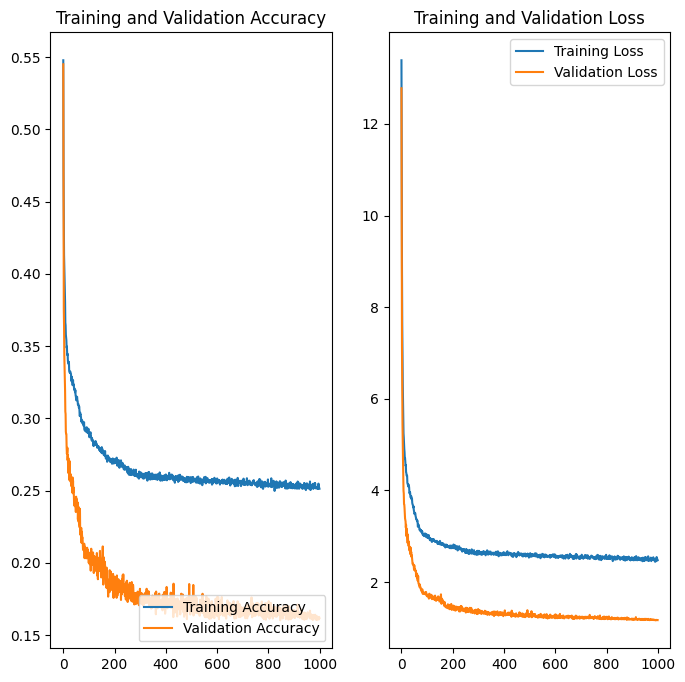

In [32]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

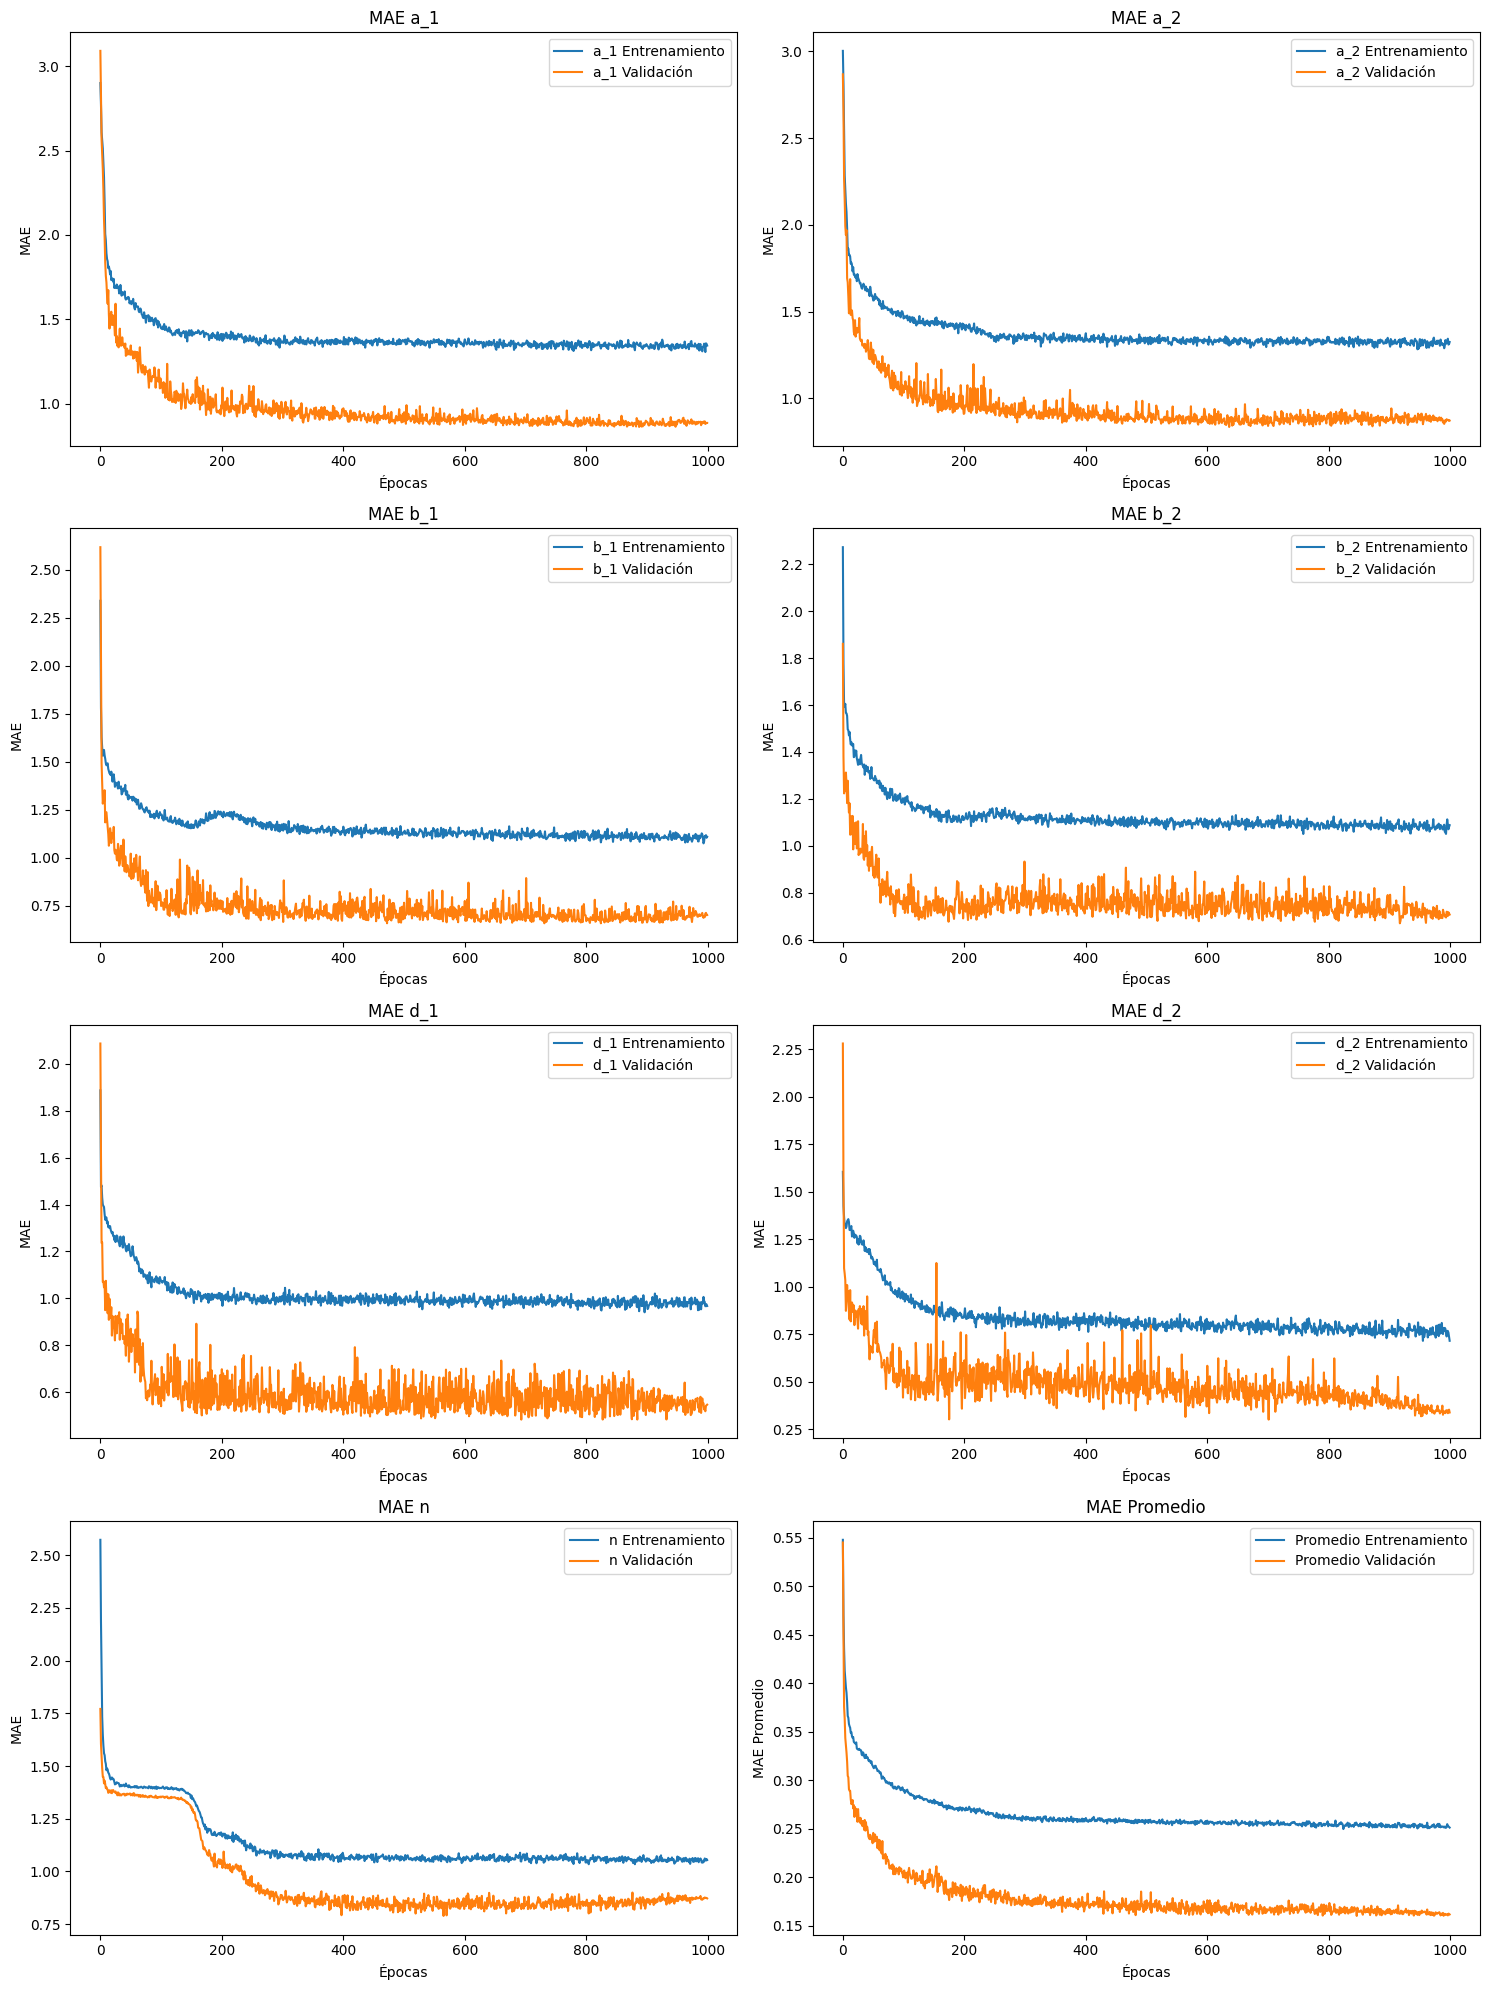

In [33]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [37]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 1ms/step - loss: 1.1538 - a_1: 0.8884 - a_2: 0.8385 - b_1: 0.6840 - b_2: 0.7012 - d_1: 0.5607 - d_2: 0.3334 - n: 0.8849 - mean_metric: 0.1613


In [39]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 710us/step


In [41]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.6988713468773017, Desviación estándar del error: 1.0455966702676869, Error absoluto máximo: 6.049107313156128


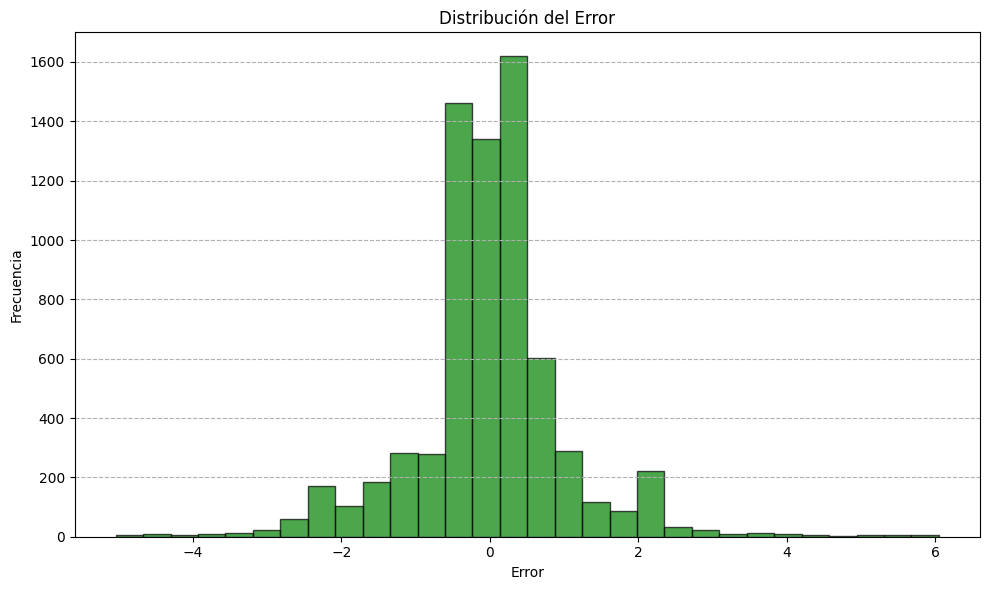

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [44]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.16739972307143597
Desviación estándar del error relativo: 0.08260572720533384
Error absoluto máximo relativo: 0.7622484707972035


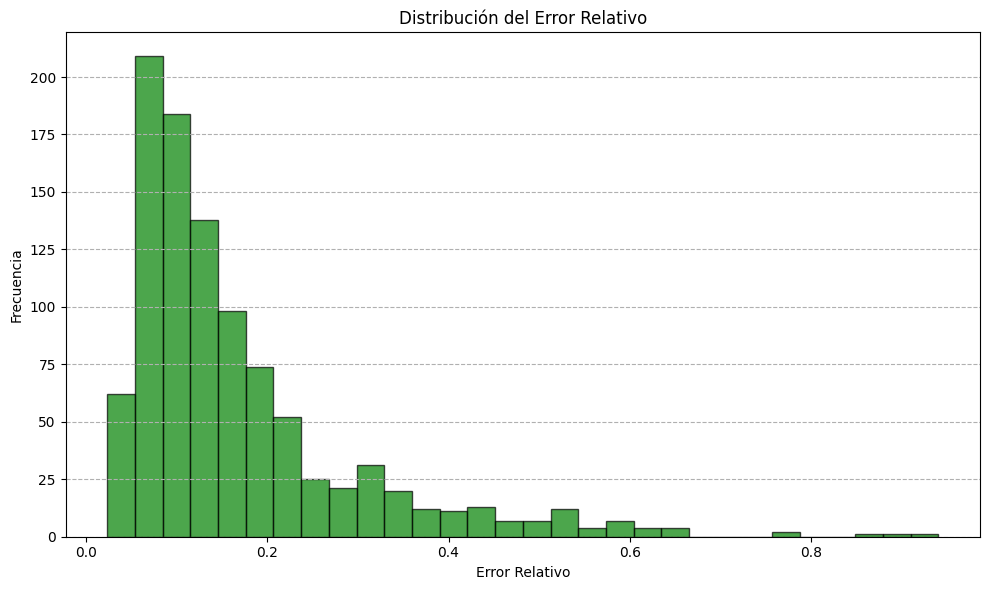

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos accuracy y loss

In [46]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historycampvec50.csv', index=False)

# Guardamos el modelo

In [47]:
path_to_save = '../../../Modelos/Modelos 50,100'

In [48]:
model.save(path_to_save + '/campovectorial50.h5')

# Importamos el modelo

In [49]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [50]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [51]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/campovectorial50.h5', custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [44]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 50)
    y2 = np.linspace(y_range_neg, y_range_pos, 50)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[6, 4, 3, 6, 4, 9, 1]


In [45]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [46]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 50ms/step
[[5. 4. 3. 5. 4. 9. 2.]]


## Encontramos puntos de equilibrio datos reales

In [47]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.7535169457215285, 0.4947430697560692)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

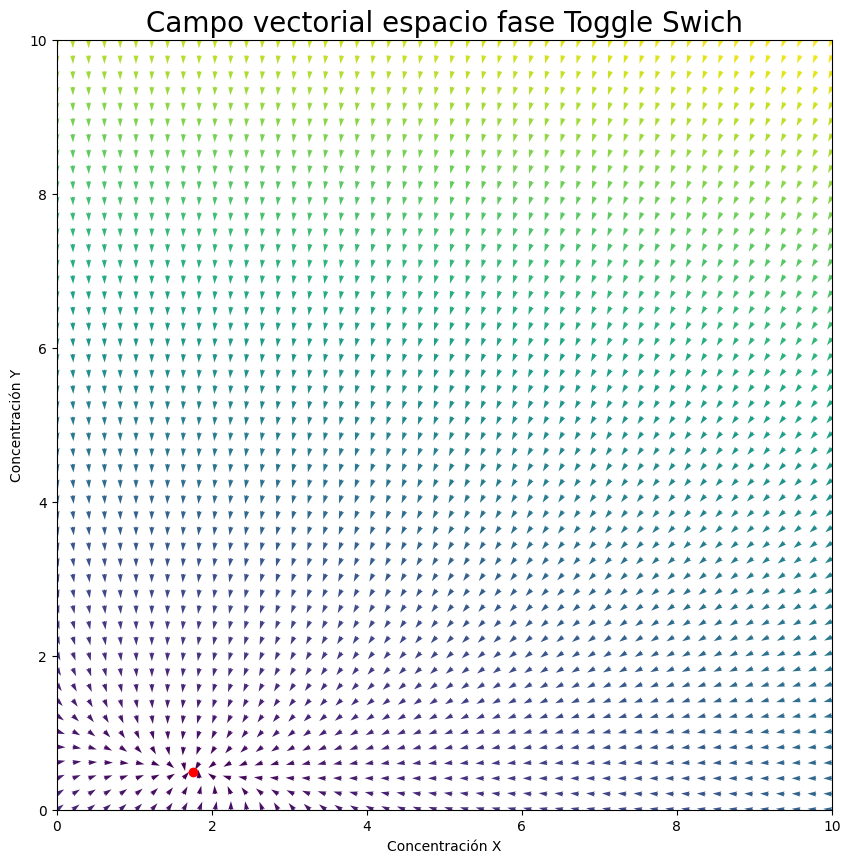

In [48]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 50)
y2 = np.linspace(0, 10, 50)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [49]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.7985777054052547, 0.43828182295290885)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

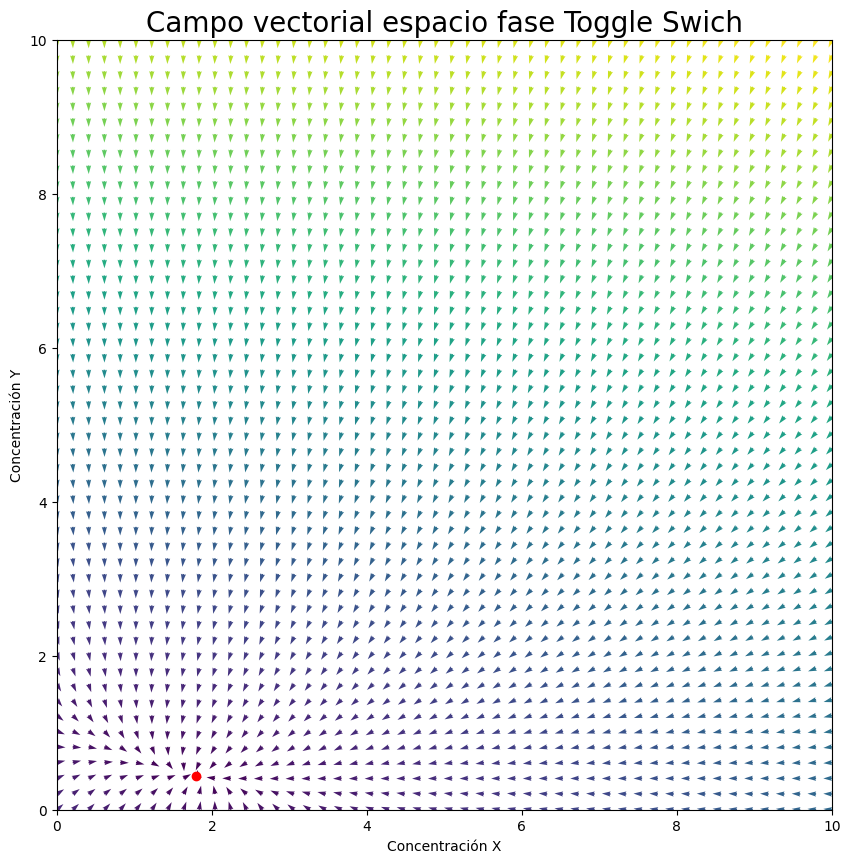

In [50]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 50)
y2pred = np.linspace(y_range_neg, y_range_pos, 50)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

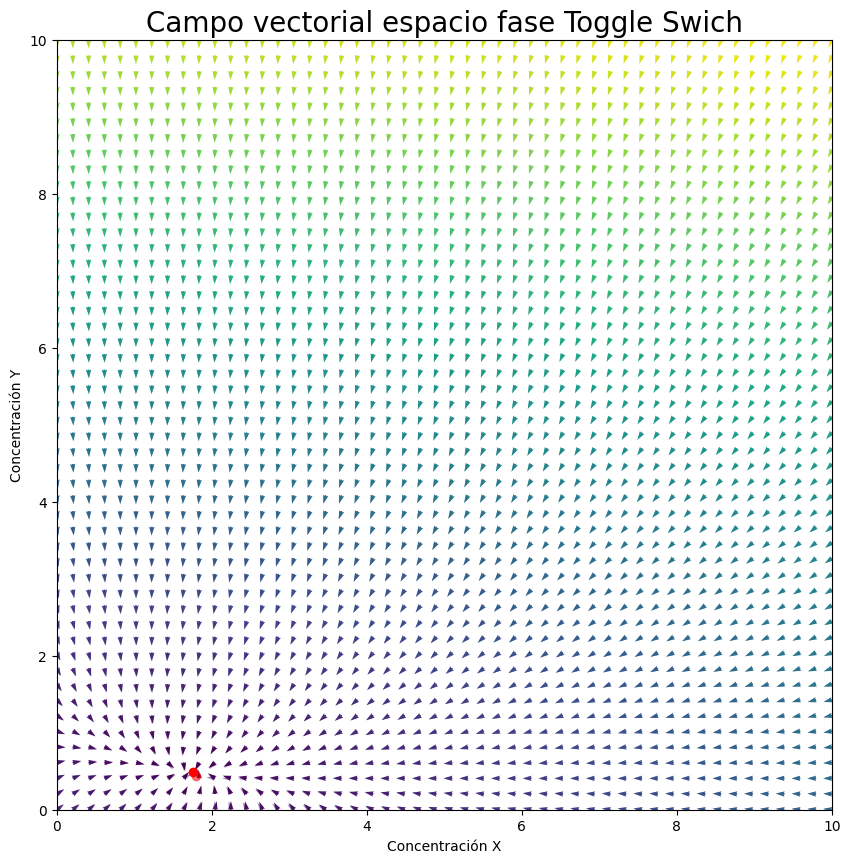

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

14.951750714775743


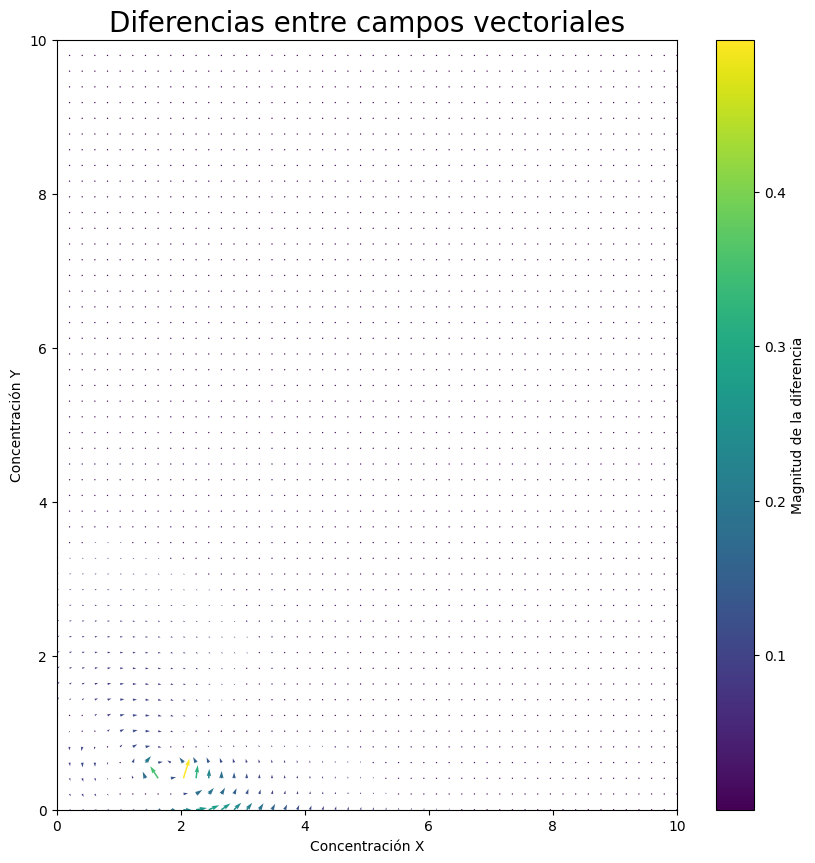

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

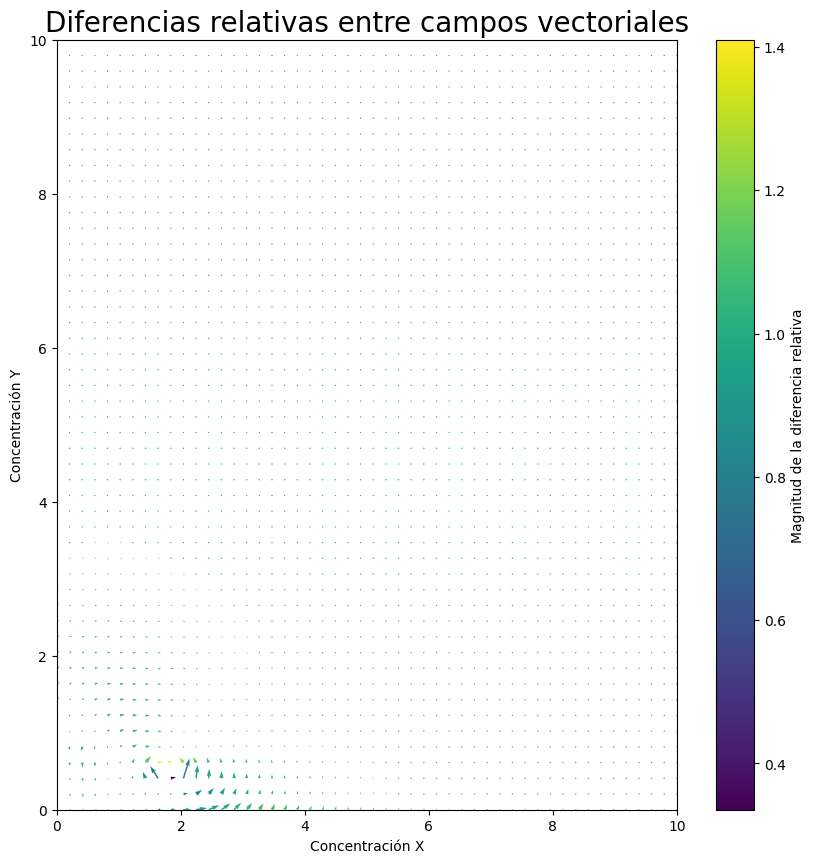

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [54]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 1.4101709323988052
El valor de u1 en el error relativo máximo es: 0.19090674244381267
El valor de u1pred en el error relativo máximo es: 0.10616448942497314
El valor de v1 en el error relativo máximo es: -0.9908242366714131
El valor de v1pred en el error relativo máximo es: -1.4189644497726377
